In [1]:
# Install dependencies (run this in a notebook cell, not needed in code below)
!pip install transformers datasets seqeval torch
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
 

In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import random

# Set device
device = 0 if torch.cuda.is_available() else -1
print(f"Device set to use {'cuda:0' if device == 0 else 'cpu'}")

# Load dataset
dataset = load_dataset("dell-research-harvard/newswire")
full_data = dataset["train"]

# Select 10000 random rows from the dataset
random.seed(42)  # Set seed for reproducibility
indices = random.sample(range(len(full_data)), 10000)  # Randomly sample
small_corpus = full_data.select(indices)  # Select the rows based on these indices

# Shuffle and split
random.seed(42)
indices = list(range(len(small_corpus)))
random.shuffle(indices)
split_idx = int(0.8 * len(indices))
train_data = small_corpus.select(indices[:split_idx])
test_data = small_corpus.select(indices[split_idx:])

# Optional: use smaller subset for testing speed (already done above by selecting 1000 samples)
#test_data = test_data.select(range(100))

# Define standard CoNLL-style label names
label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG",
    "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Define prediction function
def get_predictions(model_name, test_data):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    pipe = TokenClassificationPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

    true_labels, pred_labels = [], []

    for row in test_data:
        words = row["ner_words"]
        gold = row["ner_labels"]  # Already string labels
        sentence = " ".join(words)

        prediction = pipe(sentence)

        # Initialize with "O"
        pred_seq = ["O"] * len(words)

        for ent in prediction:
            entity = ent.get("entity_group", ent.get("entity"))
            word = ent["word"]

            # Match predicted word to a token
            for idx, w in enumerate(words):
                if word.lower() in w.lower() and pred_seq[idx] == "O":
                    pred_seq[idx] = "B-" + entity
                    break

        gold_seq = gold  # Already string labels
        true_labels.append(gold_seq)
        pred_labels.append(pred_seq)

    return true_labels, pred_labels


# Define evaluation function
def evaluate_model(name, true_labels, pred_labels):
    print(f"\n=== {name} ===")
    print("Precision:", precision_score(true_labels, pred_labels))
    print("Recall:", recall_score(true_labels, pred_labels))
    print("F1 Score:", f1_score(true_labels, pred_labels))
    print("\nDetailed Report:\n", classification_report(true_labels, pred_labels))

# Evaluate Historical NER model
model_custom = "dell-research-harvard/historical_newspaper_ner"
true_custom, pred_custom = get_predictions(model_custom, test_data)
evaluate_model("Custom Historical Newspaper NER", true_custom, pred_custom)

# Evaluate RoBERTa-Large NER model
model_roberta = "Jean-Baptiste/roberta-large-ner-english"
true_roberta, pred_roberta = get_predictions(model_roberta, test_data)
evaluate_model("RoBERTa-Large (CoNLL03)", true_roberta, pred_roberta)


Device set to use cuda:0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

1881_data_clean.json:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

1883_data_clean.json:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

1892_data_clean.json:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

1886_data_clean.json:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

1884_data_clean.json:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

1885_data_clean.json:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

1880_data_clean.json:   0%|          | 0.00/26.8M [00:00<?, ?B/s]

1887_data_clean.json:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

1891_data_clean.json:   0%|          | 0.00/108M [00:00<?, ?B/s]

1893_data_clean.json:   0%|          | 0.00/103M [00:00<?, ?B/s]

1890_data_clean.json:   0%|          | 0.00/95.3M [00:00<?, ?B/s]

1878_data_clean.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

1889_data_clean.json:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

1882_data_clean.json:   0%|          | 0.00/29.3M [00:00<?, ?B/s]

1888_data_clean.json:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

1879_data_clean.json:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

1894_data_clean.json:   0%|          | 0.00/113M [00:00<?, ?B/s]

1895_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1896_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1898_data_clean.json:   0%|          | 0.00/147M [00:00<?, ?B/s]

1897_data_clean.json:   0%|          | 0.00/139M [00:00<?, ?B/s]

1899_data_clean.json:   0%|          | 0.00/135M [00:00<?, ?B/s]

1900_data_clean.json:   0%|          | 0.00/123M [00:00<?, ?B/s]

1901_data_clean.json:   0%|          | 0.00/111M [00:00<?, ?B/s]

1902_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1903_data_clean.json:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

1904_data_clean.json:   0%|          | 0.00/106M [00:00<?, ?B/s]

1905_data_clean.json:   0%|          | 0.00/105M [00:00<?, ?B/s]

1906_data_clean.json:   0%|          | 0.00/116M [00:00<?, ?B/s]

1907_data_clean.json:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

1908_data_clean.json:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1909_data_clean.json:   0%|          | 0.00/114M [00:00<?, ?B/s]

1910_data_clean.json:   0%|          | 0.00/127M [00:00<?, ?B/s]

1911_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1912_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1913_data_clean.json:   0%|          | 0.00/125M [00:00<?, ?B/s]

1915_data_clean.json:   0%|          | 0.00/120M [00:00<?, ?B/s]

1916_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1914_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1917_data_clean.json:   0%|          | 0.00/166M [00:00<?, ?B/s]

1918_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1919_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1922_data_clean.json:   0%|          | 0.00/375M [00:00<?, ?B/s]

1920_data_clean.json:   0%|          | 0.00/368M [00:00<?, ?B/s]

1921_data_clean.json:   0%|          | 0.00/380M [00:00<?, ?B/s]

1924_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1923_data_clean.json:   0%|          | 0.00/381M [00:00<?, ?B/s]

1925_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1926_data_clean.json:   0%|          | 0.00/379M [00:00<?, ?B/s]

1927_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1928_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1929_data_clean.json:   0%|          | 0.00/460M [00:00<?, ?B/s]

1932_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1930_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1931_data_clean.json:   0%|          | 0.00/442M [00:00<?, ?B/s]

1933_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1934_data_clean.json:   0%|          | 0.00/472M [00:00<?, ?B/s]

1935_data_clean.json:   0%|          | 0.00/461M [00:00<?, ?B/s]

1936_data_clean.json:   0%|          | 0.00/445M [00:00<?, ?B/s]

1937_data_clean.json:   0%|          | 0.00/450M [00:00<?, ?B/s]

1938_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1939_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1940_data_clean.json:   0%|          | 0.00/426M [00:00<?, ?B/s]

1941_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1942_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1943_data_clean.json:   0%|          | 0.00/501M [00:00<?, ?B/s]

1944_data_clean.json:   0%|          | 0.00/516M [00:00<?, ?B/s]

1945_data_clean.json:   0%|          | 0.00/499M [00:00<?, ?B/s]

1947_data_clean.json:   0%|          | 0.00/540M [00:00<?, ?B/s]

1946_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1948_data_clean.json:   0%|          | 0.00/504M [00:00<?, ?B/s]

1949_data_clean.json:   0%|          | 0.00/507M [00:00<?, ?B/s]

1950_data_clean.json:   0%|          | 0.00/517M [00:00<?, ?B/s]

1951_data_clean.json:   0%|          | 0.00/537M [00:00<?, ?B/s]

1952_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1953_data_clean.json:   0%|          | 0.00/630M [00:00<?, ?B/s]

1955_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1954_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1956_data_clean.json:   0%|          | 0.00/605M [00:00<?, ?B/s]

1957_data_clean.json:   0%|          | 0.00/622M [00:00<?, ?B/s]

1958_data_clean.json:   0%|          | 0.00/597M [00:00<?, ?B/s]

1959_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1960_data_clean.json:   0%|          | 0.00/582M [00:00<?, ?B/s]

1961_data_clean.json:   0%|          | 0.00/561M [00:00<?, ?B/s]

1962_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1963_data_clean.json:   0%|          | 0.00/557M [00:00<?, ?B/s]

1964_data_clean.json:   0%|          | 0.00/560M [00:00<?, ?B/s]

1965_data_clean.json:   0%|          | 0.00/510M [00:00<?, ?B/s]

1966_data_clean.json:   0%|          | 0.00/506M [00:00<?, ?B/s]

1967_data_clean.json:   0%|          | 0.00/502M [00:00<?, ?B/s]

1968_data_clean.json:   0%|          | 0.00/471M [00:00<?, ?B/s]

1969_data_clean.json:   0%|          | 0.00/482M [00:00<?, ?B/s]

1970_data_clean.json:   0%|          | 0.00/473M [00:00<?, ?B/s]

1972_data_clean.json:   0%|          | 0.00/441M [00:00<?, ?B/s]

1971_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1973_data_clean.json:   0%|          | 0.00/419M [00:00<?, ?B/s]

1974_data_clean.json:   0%|          | 0.00/421M [00:00<?, ?B/s]

1975_data_clean.json:   0%|          | 0.00/423M [00:00<?, ?B/s]

1976_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1977_data_clean.json:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Custom Historical Newspaper NER ===
Precision: 0.806274078150798
Recall: 0.04392276788391197
F1 Score: 0.08330727019419407

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.91      0.12      0.20     11169
        MISC       0.36      0.01      0.02      7775
         ORG       0.61      0.02      0.04      4662
         PER       0.35      0.00      0.00      9748

   micro avg       0.81      0.04      0.08     33354
   macro avg       0.55      0.04      0.07     33354
weighted avg       0.57      0.04      0.08     33354



tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0



=== RoBERTa-Large (CoNLL03) ===
Precision: 0.150997150997151
Recall: 0.0015890148108172932
F1 Score: 0.003144933986055481

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.35      0.00      0.00     11169
        MISC       0.21      0.00      0.00      7775
         ORG       0.03      0.00      0.00      4662
         PER       0.12      0.00      0.00      9748

   micro avg       0.15      0.00      0.00     33354
   macro avg       0.18      0.00      0.00     33354
weighted avg       0.21      0.00      0.00     33354



In [3]:
print(full_data)

Dataset({
    features: ['article', 'byline', 'dates', 'newspaper_metadata', 'antitrust', 'civil_rights', 'crime', 'govt_regulation', 'labor_movement', 'politics', 'protests', 'ca_topic', 'ner_words', 'ner_labels', 'wire_city', 'wire_state', 'wire_country', 'wire_coordinates', 'wire_location_notes', 'people_mentioned', 'cluster_size', 'year'],
    num_rows: 2719607
})


In [6]:
models_to_compare = {
    "Custom Historical Newspaper NER": "dell-research-harvard/historical_newspaper_ner",
    "BERT-Large (ConLL03)": "dbmdz/bert-large-cased-finetuned-conll03-english",
    "DistilBERT (ConLL03)": "elastic/distilbert-base-uncased-finetuned-conll03-english",
    "RoBERTa-Large (ConLL03)": "Jean-Baptiste/roberta-large-ner-english"
}


In [14]:
# Dictionary to store the metrics of each model
detailed_results = {}
results = {}

for model_desc, model_name in models_to_compare.items():
    print(f"Testing {model_desc} ...")
    true_labels, pred_labels = get_predictions(model_name, test_data)

    # save reults
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    results[model_desc] = {"Precision": precision, "Recall": recall, "F1 Score": f1}

    # create classification_report and save it on detailed_results
    report_dict = classification_report(true_labels, pred_labels, output_dict=True)
    detailed_results[model_desc] = report_dict

    print(f"Finished {model_desc}.")

Testing Custom Historical Newspaper NER ...


Device set to use cuda:0


Finished Custom Historical Newspaper NER.
Testing BERT-Large (ConLL03) ...


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Finished BERT-Large (ConLL03).
Testing DistilBERT (ConLL03) ...


Device set to use cuda:0


Finished DistilBERT (ConLL03).
Testing RoBERTa-Large (ConLL03) ...


Device set to use cuda:0


Finished RoBERTa-Large (ConLL03).


In [15]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\nModel Evaluation Summary")
print(results_df)



Model Evaluation Summary
                                 Precision    Recall  F1 Score
BERT-Large (ConLL03)              0.628580  0.327067  0.430259
DistilBERT (ConLL03)              0.540805  0.334772  0.413548
Custom Historical Newspaper NER   0.806274  0.043923  0.083307
RoBERTa-Large (ConLL03)           0.150997  0.001589  0.003145


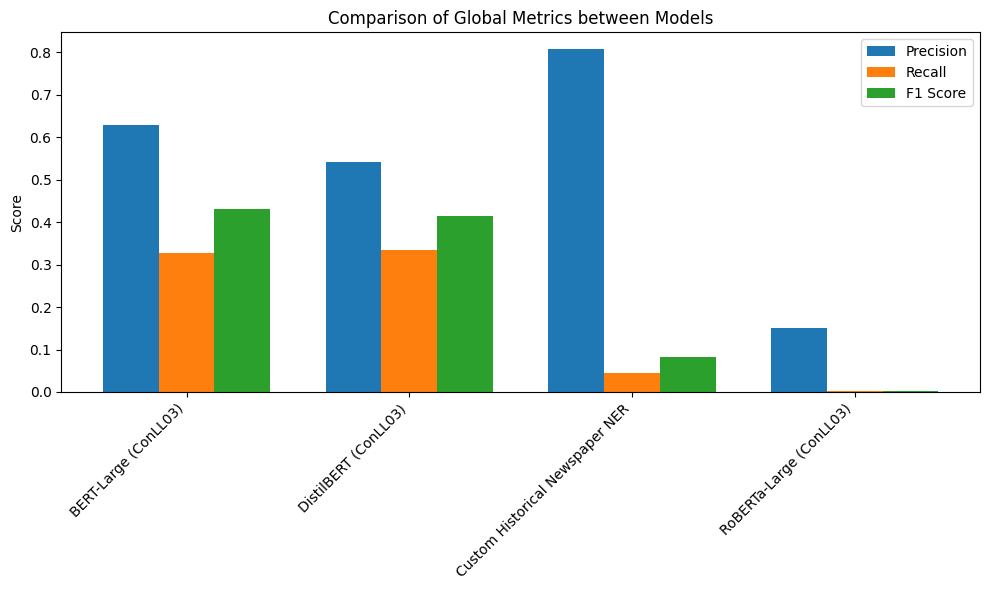

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# convert to data frame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df))
bar_width = 0.25

ax.bar([i - bar_width for i in x], results_df['Precision'], width=bar_width, label='Precision')
ax.bar(x, results_df['Recall'], width=bar_width, label='Recall')
ax.bar([i + bar_width for i in x], results_df['F1 Score'], width=bar_width, label='F1 Score')

ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Comparison of Global Metrics between Models")
ax.legend()
plt.tight_layout()
plt.show()



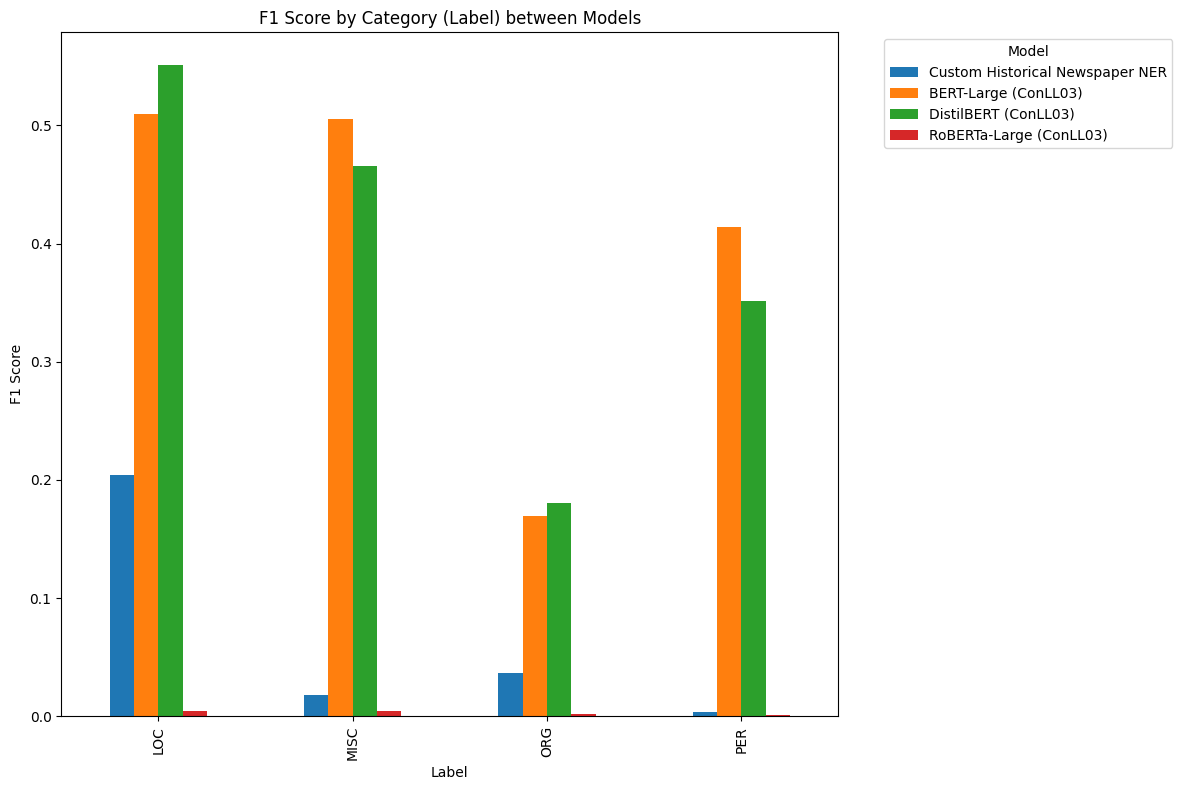

In [18]:
# F1 by category

# dataframe that contains F1 Score for each label

# get all labels
all_labels = []
for model_name, detail in detailed_results.items():
    for label in detail.keys():
        if label not in ['micro avg', 'macro avg', 'weighted avg', 'accuracy']:
            all_labels.append(label)
all_labels = sorted(set(all_labels))

# create dictionary
data = {}
for model_name, detail in detailed_results.items():
    data[model_name] = {}
    for label in all_labels:
        score = detail.get(label, {}).get('f1-score', 0)
        data[model_name][label] = score

df_labels = pd.DataFrame(data)

# plot
df_labels.plot(kind="bar", figsize=(12, 8))
plt.title("F1 Score by Category (Label) between Models")
plt.ylabel("F1 Score")
plt.xlabel("Label")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
